In [1]:
from cloudvolume import CloudVolume
from caveclient import CAVEclient
import navis
from navis import TreeNeuron
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time
from tqdm import tqdm
import json
import uuid  
from datetime import datetime, timedelta
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from scipy.spatial import distance, distance_matrix, cKDTree
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import cloudvolume as cv
from dateutil import parser
import pcg_skel
from meshparty import skeleton, trimesh_io
from dateutil import parser

navis.patch_cloudvolume()

vol = cv.CloudVolume("precomputed://gs://zheng_mouse_hippocampus_production/v2/seg_m195", use_https=True, progress=False) # new from Will
seg = cv.CloudVolume("graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3", use_https=True) # old

client = CAVEclient('zheng_ca3')
auth = client.auth

# CloudVolume and Cave setup
sv = CloudVolume('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', use_https=True, lru_bytes=int(1e8))

INFO  : cloud-volume successfully patched! (navis)


In [ ]:
df = pd.read_csv("all_pyramidal_cells - all_pyr_v2_remove_dupes.csv")
pyr_df = pd.read_csv('ca3_coms_20240730042146-Copy1.csv')

### Axon and Dendrite Only Edits

In [14]:
def update_segids_df(df, super_voxel_col):
    # Get the current date
    current_date = datetime.now().strftime('%Y%m%d')  # Format: YYYYMMDD
    
    # Update segids
    updated_segid_list = client.chunkedgraph.get_roots(df[super_voxel_col])
    
    # Add the updated segids to the DataFrame with the date in the column name
    updated_col_name = f"updated_segids_{current_date}"
    df[updated_col_name] = updated_segid_list
    
    print(f"Number of updated segids: {len(df)}")

    return df, updated_segid_list, current_date


def build_skeleton_from_pcg(SID, client):
    pcg_skeleton = pcg_skel.pcg_skeleton(root_id=SID, client=client, root_point_resolution=True)

    if pcg_skeleton.edges.shape[0] < 1 or pcg_skeleton.vertices.shape[0] < 2:
        raise ValueError(f"Malformed PCG skeleton for SID {SID} (too few edges or vertices)")
    
    G = nx.Graph()
    G.add_edges_from(pcg_skeleton.edges)

    # Convert root to int to avoid 'unhashable type' error
    bfs_edges = list(nx.bfs_edges(G, source=int(pcg_skeleton.root)))

    parent_map = {child: parent for parent, child in bfs_edges}
    parent_ids = [parent_map.get(i, -1) for i in range(len(pcg_skeleton.vertices))]

    df_skeleton = pd.DataFrame({
        'node_id': range(len(pcg_skeleton.vertices)),
        'x': pcg_skeleton.vertices[:, 0],
        'y': pcg_skeleton.vertices[:, 1],
        'z': pcg_skeleton.vertices[:, 2],
        'parent_id': parent_ids
    })

    navis_skel = navis.TreeNeuron(x=df_skeleton)
    healed_skel = navis.heal_skeleton(navis_skel)

    return healed_skel


def analyze_proofreading_metrics(csv_path, client, vol, navis_TF=True, navis_type='wavefront'):
    df = pd.read_csv(csv_path)
    df = df[df['Pyramidal?'] == 'Yes']
    df = df[df['axon_length'] >= 500]
    #df = df.head(3)
    
    all_results = []
    
    df, updated_segid_list, current_date = update_segids_df(df, super_voxel_col='supervoxel')
    
    for SID in tqdm(updated_segid_list, desc='Processing Proofreading Metrics'):
        try:
            # Setup
            current_date = datetime.now().strftime('%Y%m%d')
            row = df[df[f"updated_segids_{current_date}"] == SID]

            if row.empty:
                continue

            AIS = row[['ais_x', 'ais_y', 'ais_z']].astype(float).values[0]
            AIS = np.array([AIS[0] * 18, AIS[1] * 18, AIS[2] * 45])

            # Get mesh and skeleton
            if navis_TF:
                mesh_list = vol.mesh.get_navis(SID)
                if navis_type == 'teasar':
                    skel = navis.skeletonize(mesh_list, method='teasar', inv_dist=1000)
                else:
                    skel = navis.skeletonize(mesh_list)
                healed_skel = navis.heal_skeleton(skel[0])
            else:
                healed_skel = build_skeleton_from_pcg(SID, client)
                #print('check1')
                
            # Extract node coordinates from skeleton
            node_coords = healed_skel.nodes[['x', 'y', 'z']].values

            # Find node closest to AIS
            distances = np.linalg.norm(node_coords - AIS, axis=1)
            closest_idx = np.argmin(distances)
            closest_node_id = healed_skel.nodes.iloc[closest_idx]['node_id']

            # Cut skeleton at closest node
            skel_dist = navis.cut_skeleton(healed_skel, closest_node_id, ret='both')
            if len(skel_dist) < 2:
                continue

            # Assign axon/dendrite
            #axon_skel = skel_dist[np.argmin([n.n_nodes for n in skel_dist])]
            #dendrite_skel = skel_dist[np.argmax([n.n_nodes for n in skel_dist])]

            # Cut skeleton at closest node to AIS
            skel_dist = navis.cut_skeleton(healed_skel, closest_node_id, ret='both')
            if len(skel_dist) < 2:
                continue

            # Identify which skeleton contains the AIS node (i.e., closest_node_id)
#            contains_AIS = [closest_node_id in skel.nodes['node_id'].values for skel in skel_dist]

            # The one containing the AIS is now considered dendrite, the other is axon
 #           dendrite_index = np.argmax(contains_AIS)
 #           dendrite_skel = skel_dist[dendrite_index]
  #          axon_skel = skel_dist[1 - dendrite_index]

            # Get nucleus coordinates from the DataFrame and scale appropriately
            nucleus = row[['x', 'y', 'z']].astype(float).values[0]
            nucleus = np.array([nucleus[0] * 18, nucleus[1] * 18, nucleus[2] * 45])

            # For each cut skeleton, find the closest node to the nucleus
            dists_to_nucleus = []
            for skel_part in skel_dist:
                skel_coords = skel_part.nodes[['x', 'y', 'z']].values
                min_dist = np.min(np.linalg.norm(skel_coords - nucleus, axis=1))
                dists_to_nucleus.append(min_dist)

            # Assign dendrite and axon based on proximity to nucleus
            dendrite_index = np.argmin(dists_to_nucleus)
            dendrite_skel = skel_dist[dendrite_index]
            axon_skel = skel_dist[1 - dendrite_index]

            # Proofreading info (always fetch this)
            change_log = client.chunkedgraph.get_tabular_change_log([SID])
            list_of_operation_ids = change_log[SID]['operation_id'].tolist()
            operation_log = client.chunkedgraph.get_operation_details(list_of_operation_ids)

            # Initialize default zero values
            axon_edit_num = 1
            dendrite_edit_num = 1
            axon_edit_duration = 1
            dendrite_edit_duration = 1
            
            # Use empty arrays for the structure we're skipping
            axon_coords = axon_skel.nodes[['x', 'y', 'z']].values 
            dend_coords = dendrite_skel.nodes[['x', 'y', 'z']].values 

            (axon_edit_num, dendrite_edit_num, axon_edit_duration, dendrite_edit_duration, axon_coords_list, dendrite_coords_list, axon_op_ids, dendrite_op_ids) = compute_edits_and_durations(operation_log, axon_coords, dend_coords)
          
            # Save results
            df_result = {
                'SegID': SID,
                'Num. Axon Edits': axon_edit_num,
                'Num. Dendrite Edits': dendrite_edit_num,
                'Skel Axon Length (um)': axon_skel.cable_length / 1000,
                'Sheet Axon Length (um)': row['axon_length'].astype(float).values[0],
                'Dendrite Length (um)': dendrite_skel.cable_length / 1000,
                'Axon Edit Time': axon_edit_duration / 60,
                'Dendrite Edit Time': dendrite_edit_duration / 60,
                'Axon Proofreading Rate (um / min)': (axon_skel.cable_length / 1000) / (axon_edit_duration / 60),
                'Axon Sheet Proofreading Rate (um / min)': (row['axon_length'].astype(float).values[0]) / (axon_edit_duration / 60),
                'Dendrite Proofreading Rate (um / min)': (dendrite_skel.cable_length / 1000) / (dendrite_edit_duration / 60),
                'All Axon Edit Coordinates': [axon_coords_list],
                'All Dendrite Edit Coordinates': [dendrite_coords_list],
                'Axon Operation IDs': [axon_op_ids],
                'Dendrite Operation IDs': [dendrite_op_ids]
            }
            all_results.append(df_result)
            
            plot_axon_dendrite_edits_3D(SID, axon_skel, dendrite_skel, axon_coords_list, dendrite_coords_list, AIS)

        except Exception as e:
            print(f"Error processing SID {SID}: {e}")
            continue

    results_df = pd.DataFrame(all_results)
    results_df.to_csv('AxonDendrite_Proofreading_Metrics-test.csv')
    
    return results_df


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_axon_dendrite_edits_3D(SID, axon_skel, dendrite_skel, axon_coords_list, dendrite_coords_list, AIS):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot axon skeleton (green)
    for i, row in axon_skel.nodes.iterrows():
        parent_id = row['parent_id']
        if parent_id == -1:
            continue
        parent_row = axon_skel.nodes.loc[axon_skel.nodes['node_id'] == parent_id]
        if parent_row.empty:
            continue
        x_vals = [row['x'], parent_row['x'].values[0]]
        y_vals = [row['y'], parent_row['y'].values[0]]
        z_vals = [row['z'], parent_row['z'].values[0]]
        ax.plot(x_vals, y_vals, z_vals, color='green', linewidth=1)

    # Plot dendrite skeleton (red, narrow lines)
    for i, row in dendrite_skel.nodes.iterrows():
        parent_id = row['parent_id']
        if parent_id == -1:
            continue
        parent_row = dendrite_skel.nodes.loc[dendrite_skel.nodes['node_id'] == parent_id]
        if parent_row.empty:
            continue
        x_vals = [row['x'], parent_row['x'].values[0]]
        y_vals = [row['y'], parent_row['y'].values[0]]
        z_vals = [row['z'], parent_row['z'].values[0]]
        ax.plot(x_vals, y_vals, z_vals, color='red', linewidth=0.5)

    # Plot axon edit points (blue)
    if axon_coords_list:
        axon_coords = np.array(axon_coords_list)
        ax.scatter(axon_coords[:, 0]*18, axon_coords[:, 1]*18, axon_coords[:, 2]*45, color='blue', label='Axon Edits', s=10)

    # Plot dendrite edit points (black)
    if dendrite_coords_list:
        dend_coords = np.array(dendrite_coords_list)
        ax.scatter(dend_coords[:, 0]*18, dend_coords[:, 1]*18, dend_coords[:, 2]*45, color='black', label='Dendrite Edits', s=10)

        # Plot AIS as a large yellow dot
    ax.scatter(AIS[0], AIS[1], AIS[2], color='yellow', s=100, label='AIS')
    ax.set_title(f"SID {SID} - Axon & Dendrite Skeletons")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"{SID}_axon_dendrite_plot_test.png", dpi=300)
    plt.close()


def compute_edits_and_durations(operation_log, axon_skel, dendrite_skel):
    axon_edit_num = 0
    dendrite_edit_num = 0
    axon_edit_duration = 0.0
    dendrite_edit_duration = 0.0

    axon_coords_list = []
    dendrite_coords_list = []
    axon_op_ids = []
    dendrite_op_ids = []

    def min_distance(coord, skel):
        coord = np.array(coord)
        skel = np.array(skel)
        if coord.size == 0 or skel.size == 0:
            return np.inf
        return np.min(np.linalg.norm(coord - skel, axis=1))

    op_list = []
    seen_coords = []

    for op_id, op in operation_log.items():
        ts = parser.parse(op['operation_ts'])

        scaled_coords = []

        if 'source_coords' in op:
            scaled_coords.extend([[x * 18, y * 18, z * 45] for x, y, z in op['source_coords']])
        if 'sink_coords' in op:
            scaled_coords.extend([[x * 18, y * 18, z * 45] for x, y, z in op['sink_coords']])

        if not scaled_coords:
            continue

        # Compute average coordinate for this operation
        avg_coord = np.mean(scaled_coords, axis=0)

        # Check if this coordinate is within 10,000 of any already-kept one
        too_close = any(np.linalg.norm(avg_coord - np.array(existing)) < 10000 for existing in seen_coords)
        if too_close:
            continue

        seen_coords.append(avg_coord.tolist())

        # Determine distance to axon/dendrite
        dist_to_axon = min_distance(avg_coord, axon_skel)
        dist_to_dend = min_distance(avg_coord, dendrite_skel)
        label = 'axon' if dist_to_axon < dist_to_dend else 'dendrite'

        # Scale back to voxel space
        unscaled_coord = [avg_coord[0] / 18, avg_coord[1] / 18, avg_coord[2] / 45]

        if label == 'axon':
            axon_edit_num += 1
            axon_coords_list.append(unscaled_coord)
            axon_op_ids.append(op_id)
        else:
            dendrite_edit_num += 1
            dendrite_coords_list.append(unscaled_coord)
            dendrite_op_ids.append(op_id)

        op_list.append({'timestamp': ts, 'label': label})

    op_list.sort(key=lambda x: x['timestamp'])

    for i in range(1, len(op_list)):
        prev = op_list[i - 1]
        curr = op_list[i]
        delta = (curr['timestamp'] - prev['timestamp']).total_seconds()
        if delta <= 900:
            if curr['label'] == 'axon':
                axon_edit_duration += delta
            else:
                dendrite_edit_duration += delta

    if axon_edit_duration == 0:
        axon_edit_duration = 1
    if dendrite_edit_duration == 0:
        dendrite_edit_duration = 1

    return (
        axon_edit_num, dendrite_edit_num,
        axon_edit_duration, dendrite_edit_duration,
        axon_coords_list, dendrite_coords_list,
        axon_op_ids, dendrite_op_ids
    )

In [15]:
csv_path = "all_pyramidal_cells - all_pyr_v2_remove_dupes.csv"
results = analyze_proofreading_metrics(csv_path, client, vol, navis_TF=False, navis_type='teasar')

Number of updated segids: 208


Processing Proofreading Metrics:   7%|▋        | 15/208 [01:32<19:56,  6.20s/it]


KeyboardInterrupt: 

In [75]:
results = pd.read_csv('AxonDendrite_Proofreading_Metrics.csv')

In [78]:
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

def filter_close_axon_coords(results_old, distance_threshold=10000,
                             output_dir_plotly="axon_edit_html",
                             output_dir_matplotlib="axon_edit_png"):
    
    os.makedirs(output_dir_plotly, exist_ok=True)
    os.makedirs(output_dir_matplotlib, exist_ok=True)

    filtered_coords_list = []
    filtered_counts = []
    filtered_ids_list = []

    for idx, row in results_old.iterrows():
        raw_coords = row["All Axon Edit Coordinates"]
        raw_ids = row["Axon Operation IDs"]
        segid_raw = row.get("SegID", f"Idx_{idx}")
        segid = str(int(segid_raw)) if isinstance(segid_raw, (int, float)) else str(segid_raw)

        try:
            coords = ast.literal_eval(raw_coords) if isinstance(raw_coords, str) else raw_coords
            ids = ast.literal_eval(raw_ids) if isinstance(raw_ids, str) else raw_ids
        except Exception:
            filtered_coords_list.append([])
            filtered_ids_list.append([])
            filtered_counts.append(0)
            continue

        if not coords or not isinstance(coords, list):
            coord_list = []
        elif isinstance(coords[0], list) and len(coords[0]) > 0 and isinstance(coords[0][0], (int, float)):
            coord_list = coords
        elif isinstance(coords[0], list):
            coord_list = coords[0]
        else:
            coord_list = []

        if not ids or not isinstance(ids, list):
            id_list = []
        elif isinstance(ids[0], list):
            id_list = ids[0]
        else:
            id_list = ids

        keep = []
        keep_ids = []
        seen_scaled = []
        keep_scaled = []
        removed_scaled = []
        removed_pairs = []

        for coord, op_id in zip(coord_list, id_list):
            scaled = np.array([coord[0] * 18, coord[1] * 18, coord[2] * 45])
            if any(np.linalg.norm(scaled - s) < distance_threshold for s in seen_scaled):
                distances = [np.linalg.norm(scaled - s) for s in seen_scaled]
                closest = seen_scaled[np.argmin(distances)]
                removed_scaled.append(scaled)
                removed_pairs.append((scaled, closest))
            else:
                seen_scaled.append(scaled)
                keep.append(coord)
                keep_ids.append(op_id)
                keep_scaled.append(scaled)

        filtered_coords_list.append(keep)
        filtered_ids_list.append(keep_ids)
        filtered_counts.append(len(keep))

        # Plotly Plot
        fig_p = go.Figure()

        if keep_scaled:
            ks = np.array(keep_scaled)
            fig_p.add_trace(go.Scatter3d(
                x=ks[:, 0], y=ks[:, 1], z=ks[:, 2],
                mode='markers',
                marker=dict(size=4, color='black'),
                name='Kept'
            ))

        if removed_scaled:
            rm = np.array(removed_scaled)
            fig_p.add_trace(go.Scatter3d(
                x=rm[:, 0], y=rm[:, 1], z=rm[:, 2],
                mode='markers',
                marker=dict(size=4, color='red'),
                name='Removed'
            ))

        for removed, closest in removed_pairs:
            xs, ys, zs = zip(removed, closest)
            dist_microns = np.linalg.norm(removed - closest) / 1000
            hover_text = f"{dist_microns:.1f} µm"

            fig_p.add_trace(go.Scatter3d(
                x=xs, y=ys, z=zs,
                mode='lines',
                line=dict(color='gray', width=2),
                hoverinfo='text',
                text=[hover_text, hover_text],
                showlegend=False
            ))

        fig_p.update_layout(
            title=f"Axon Edit Filtering - Row {idx}",
            scene=dict(
                xaxis_title='X (nm)',
                yaxis_title='Y (nm)',
                zaxis_title='Z (nm)'
            ),
            margin=dict(l=0, r=0, b=0, t=30),
            legend=dict(x=0, y=1),
        )

        fig_p.write_html(os.path.join(output_dir_plotly, f"axon_edits_{segid}.html"))

        # Matplotlib PNG Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        for removed, closest in removed_pairs:
            xs, ys, zs = zip(removed, closest)
            ax.plot(xs, ys, zs, color='gray', linewidth=0.5)

        if keep_scaled:
            ks_arr = np.array(keep_scaled)
            ax.scatter(ks_arr[:, 0], ks_arr[:, 1], ks_arr[:, 2],
                       c='black', label='Kept', s=20, zorder=3)
        if removed_scaled:
            rm_arr = np.array(removed_scaled)
            ax.scatter(rm_arr[:, 0], rm_arr[:, 1], rm_arr[:, 2],
                       c='red', label='Removed', s=20, zorder=3)

        for i, (removed, closest) in enumerate(removed_pairs):
            midpoint = (removed + closest) / 2
            dist_microns = np.linalg.norm(removed - closest) / 1000
            angle = i * (2 * np.pi / max(1, len(removed_pairs)))
            z_angle = (i % 3) * (np.pi / 6)
            offset = np.array([
                10000 * np.cos(angle) * np.cos(z_angle),
                10000 * np.sin(angle) * np.cos(z_angle),
                10000 * np.sin(z_angle)
            ])
            text_pos = midpoint + offset

            ax.text(text_pos[0], text_pos[1], text_pos[2],
                    f"{dist_microns:.1f} µm", fontsize=6, color='green')
            ax.plot([text_pos[0], midpoint[0]],
                    [text_pos[1], midpoint[1]],
                    [text_pos[2], midpoint[2]],
                    color='green', linewidth=0.5)

        ax.set_title(f'Axon Edit Filtering - Row {idx}')
        ax.set_xlabel('X (nm)')
        ax.set_ylabel('Y (nm)')
        ax.set_zlabel('Z (nm)')
        ax.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir_matplotlib, f"axon_edits_{segid}.png"))
        plt.close(fig)

    # Add new columns to original dataframe
    results_old["All Axon Coordinates 10000"] = filtered_coords_list
    results_old["Axon Operation IDs 10000"] = filtered_ids_list
    results_old["Num. Axon Edits 10000"] = filtered_counts

    # Expand into one row per kept coordinate/operation ID
    expanded_rows = []
    for _, row in results_old.iterrows():
        coords = row["All Axon Coordinates 10000"]
        ids = row["Axon Operation IDs 10000"]
        if not coords or not ids or len(coords) != len(ids):
            continue
        for coord, op_id in zip(coords, ids):
            new_row = row.copy()
            new_row["All Axon Coordinates 10000"] = coord
            new_row["Axon Operation IDs 10000"] = op_id
            expanded_rows.append(new_row)

    expanded_df = pd.DataFrame(expanded_rows)
    return expanded_df



In [79]:
results_old_filtered = filter_close_axon_coords(results)
results_old_filtered

/var/folders/bz/l7hrgw1544v9fdn5yxzlp_r80000gp/T/ipykernel_33942/407527985.py:163: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



,Unnamed: 0,SegID,Num. Axon Edits,Num. Dendrite Edits,Skel Axon Length (um),Sheet Axon Length (um),Dendrite Length (um),Axon Edit Time,Dendrite Edit Time,Axon Proofreading Rate (um / min),Axon Sheet Proofreading Rate (um / min),Dendrite Proofreading Rate (um / min),All Axon Edit Coordinates,All Dendrite Edit Coordinates,Axon Operation IDs,Dendrite Operation IDs,All Axon Coordinates 10000,Axon Operation IDs 10000,Num. Axon Edits 10000
0,0,648518346440007067,3,3,752.640580,755.08,522.677920,6.351700,1.287650,118.494353,118.878411,405.916142,"[[[31802.0, 71983.0, 709.0], [32545.5, 72023.0...","[[[29296.0, 70842.5, 701.0], [29257.5, 70049.0...","[['5034', '5039', '5041']]","[['591', '761', '5042']]","[31802.0, 71983.0, 709.0]",5034,3
0,0,648518346440007067,3,3,752.640580,755.08,522.677920,6.351700,1.287650,118.494353,118.878411,405.916142,"[[[31802.0, 71983.0, 709.0], [32545.5, 72023.0...","[[[29296.0, 70842.5, 701.0], [29257.5, 70049.0...","[['5034', '5039', '5041']]","[['591', '761', '5042']]","[32545.5, 72023.0, 711.0]",5039,3
0,0,648518346440007067,3,3,752.640580,755.08,522.677920,6.351700,1.287650,118.494353,118.878411,405.916142,"[[[31802.0, 71983.0, 709.0], [32545.5, 72023.0...","[[[29296.0, 70842.5, 701.0], [29257.5, 70049.0...","[['5034', '5039', '5041']]","[['591', '761', '5042']]","[27288.0, 72419.33333333333, 1256.8333333333333]",5041,3
1,1,648518346431532480,18,10,705.572341,701.59,1845.075014,6.332117,3.119150,111.427565,110.798653,591.531351,"[[[26928.0, 73329.0, 1114.5], [27710.5, 72302....","[[[29940.5, 71325.5, 1312.0], [23082.0, 69637....","[['616', '3297', '3300', '3301', '3302', '3306...","[['777', '3309', '3310', '3311', '3312', '3313...","[26928.0, 73329.0, 1114.5]",616,11
1,1,648518346431532480,18,10,705.572341,701.59,1845.075014,6.332117,3.119150,111.427565,110.798653,591.531351,"[[[26928.0, 73329.0, 1114.5], [27710.5, 72302....","[[[29940.5, 71325.5, 1312.0], [23082.0, 69637....","[['616', '3297', '3300', '3301', '3302', '3306...","[['777', '3309', '3310', '3311', '3312', '3313...","[27710.5, 72302.5, 1493.0]",3297,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,206,648518346450505390,9,9,1905.959204,1908.34,1087.013683,4.446617,7.543917,428.631327,429.166745,144.091422,"[[[45528.75, 37550.75, 1264.0], [60136.2000000...","[[[51691.0, 39660.0, 157.0], [53627.3333333333...","[['62224', '62225', '62228', '62230', '62232',...","[['55479', '62223', '62226', '62227', '62229',...","[48170.5, 32456.0, 705.5]",62237,9
206,206,648518346450505390,9,9,1905.959204,1908.34,1087.013683,4.446617,7.543917,428.631327,429.166745,144.091422,"[[[45528.75, 37550.75, 1264.0], [60136.2000000...","[[[51691.0, 39660.0, 157.0], [53627.3333333333...","[['62224', '62225', '62228', '62230', '62232',...","[['55479', '62223', '62226', '62227', '62229',...","[59850.0, 38267.5, 1847.5]",62239,9
206,206,648518346450505390,9,9,1905.959204,1908.34,1087.013683,4.446617,7.543917,428.631327,429.166745,144.091422,"[[[45528.75, 37550.75, 1264.0], [60136.2000000...","[[[51691.0, 39660.0, 157.0], [53627.3333333333...","[['62224', '62225', '62228', '62230', '62232',...","[['55479', '62223', '62226', '62227', '62229',...","[55560.0, 37955.0, 220.0]",62242,9
207,207,648518346447175520,2,9,659.740627,660.28,723.084973,0.079783,22.279300,8269.153462,8275.913934,32.455462,"[[[47861.5, 33871.0, 2004.5], [50074.0, 38496....","[[[53437.0, 39516.5, 185.0], [56801.75, 32286....","[['62027', '62028']]","[['55468', '62015', '62016', '62018', '62019',...","[47861.5, 33871.0, 2004.5]",62027,2


In [41]:
results_old_filtered.to_csv('AxonDendrite_Proofreading_Metrics-Filtered-Exploded.csv')

In [80]:
row_zero_axon = results_old_filtered[results_old_filtered['Num. Axon Edits 10000'] == 0]
print(row_zero_axon)

Empty DataFrame
Columns: [Unnamed: 0, SegID, Num. Axon Edits, Num. Dendrite Edits, Skel Axon Length (um), Sheet Axon Length (um), Dendrite Length (um), Axon Edit Time, Dendrite Edit Time, Axon Proofreading Rate (um / min), Axon Sheet Proofreading Rate (um / min), Dendrite Proofreading Rate (um / min), All Axon Edit Coordinates, All Dendrite Edit Coordinates, Axon Operation IDs, Dendrite Operation IDs, All Axon Coordinates 10000, Axon Operation IDs 10000, Num. Axon Edits 10000]
Index: []


In [81]:
segIDs_to_remove = [648518346437835193, 648518346438009049, 648518346439125956, 648518346442896776, 648518346447806970, 648518346450474414, 648518346465908367, 648518346436648491, 648518346442523696, 648518346446983839, 648518346448451806, 648518346449576911, 648518346431545024, 648518346441939851, 648518346442896776, 648518346451887558, 648518346448451806, 648518346449576911]
print(len(segIDs_to_remove))
print(len(results_old_filtered))

results_old_filtered = results_old_filtered[~results_old_filtered['SegID'].isin(segIDs_to_remove)]
print(len(results_old_filtered))

18
1933
1862


In [82]:
results_old_filtered.to_csv('AxonDendrite_Proofreading_Metrics-Filtered_V2-Exploded.csv')

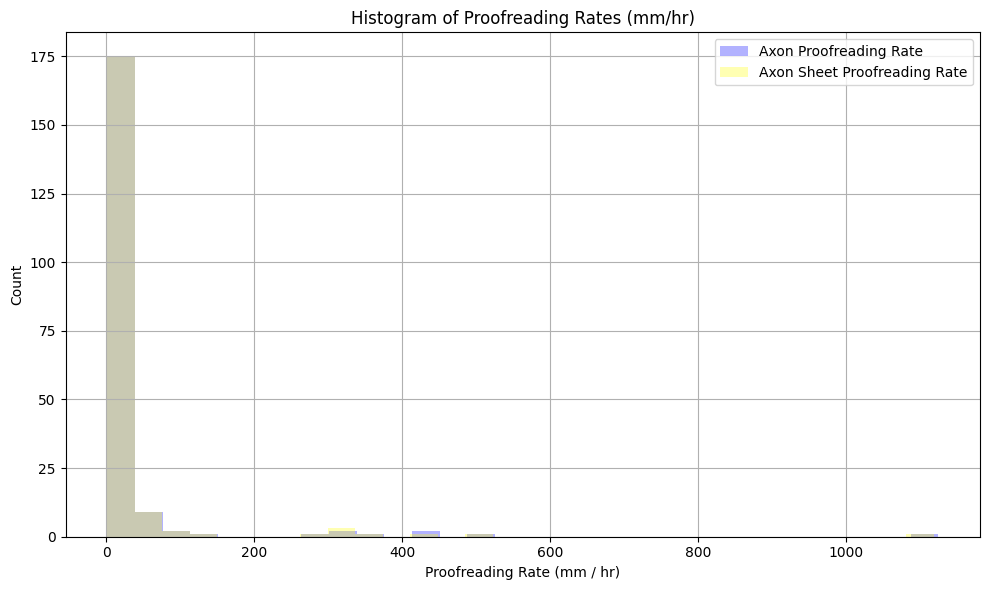

Average Proofreading Rates (µm / min):
• Axon Proofreading Rate: 509.51
• Axon Sheet Proofreading Rate: 495.96
• Dendrite Proofreading Rate: 3579.42
Top SegID by category:
• Axon Proofreading Rate: 648518346443278147
• Axon Sheet Proofreading Rate: 648518346443278147
• Dendrite Proofreading Rate: 648518346437371914


In [72]:
import matplotlib.pyplot as plt

#results = results_old_filtered
# Convert from µm/min to mm/hr
conversion_factor = 0.06

# Filter each rate independently based on its corresponding edit count
axon_rate = results.loc[results['Num. Axon Edits'] > 1, 'Axon Proofreading Rate (um / min)'] * conversion_factor
axon_sheet_rate = results.loc[results['Num. Axon Edits'] > 1, 'Axon Sheet Proofreading Rate (um / min)'] * conversion_factor
dendrite_rate = results.loc[results['Num. Dendrite Edits'] > 1, 'Dendrite Proofreading Rate (um / min)'] * conversion_factor


# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(axon_rate, bins=30, alpha=0.3, label='Axon Proofreading Rate', color='blue')
plt.hist(axon_sheet_rate, bins=30, alpha=0.3, label='Axon Sheet Proofreading Rate', color='yellow')
#plt.hist(dendrite_rate, bins=30, alpha=0.6, label='Dendrite Proofreading Rate', color='red')

plt.xlabel('Proofreading Rate (mm / hr)')
plt.ylabel('Count')
plt.title('Histogram of Proofreading Rates (mm/hr)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"Axon_Proofreading_Rate_Hist_PerCell.png", dpi=600)
plt.show()

# Filter for valid entries with > 0 edits
valid_axon = results[results['Num. Axon Edits'] > 1]
valid_dendrite = results[results['Num. Dendrite Edits'] > 1]

# Get SegID with highest rate in each group
top_axon_segID = valid_axon.loc[valid_axon['Axon Proofreading Rate (um / min)'].idxmax(), 'SegID']
top_axon_sheet_segID = valid_axon.loc[valid_axon['Axon Sheet Proofreading Rate (um / min)'].idxmax(), 'SegID']
top_dendrite_segID = valid_dendrite.loc[valid_dendrite['Dendrite Proofreading Rate (um / min)'].idxmax(), 'SegID']


# Calculate average proofreading rates (in µm/min)
avg_axon_rate = valid_axon['Axon Proofreading Rate (um / min)'].mean()
avg_axon_sheet_rate = valid_axon['Axon Sheet Proofreading Rate (um / min)'].mean()
avg_dendrite_rate = valid_dendrite['Dendrite Proofreading Rate (um / min)'].mean()

# Print results
print("Average Proofreading Rates (µm / min):")
print(f"• Axon Proofreading Rate: {avg_axon_rate:.2f}")
print(f"• Axon Sheet Proofreading Rate: {avg_axon_sheet_rate:.2f}")
print(f"• Dendrite Proofreading Rate: {avg_dendrite_rate:.2f}")
# Print results
print("Top SegID by category:")
print(f"• Axon Proofreading Rate: {top_axon_segID}")
print(f"• Axon Sheet Proofreading Rate: {top_axon_sheet_segID}")
print(f"• Dendrite Proofreading Rate: {top_dendrite_segID}")


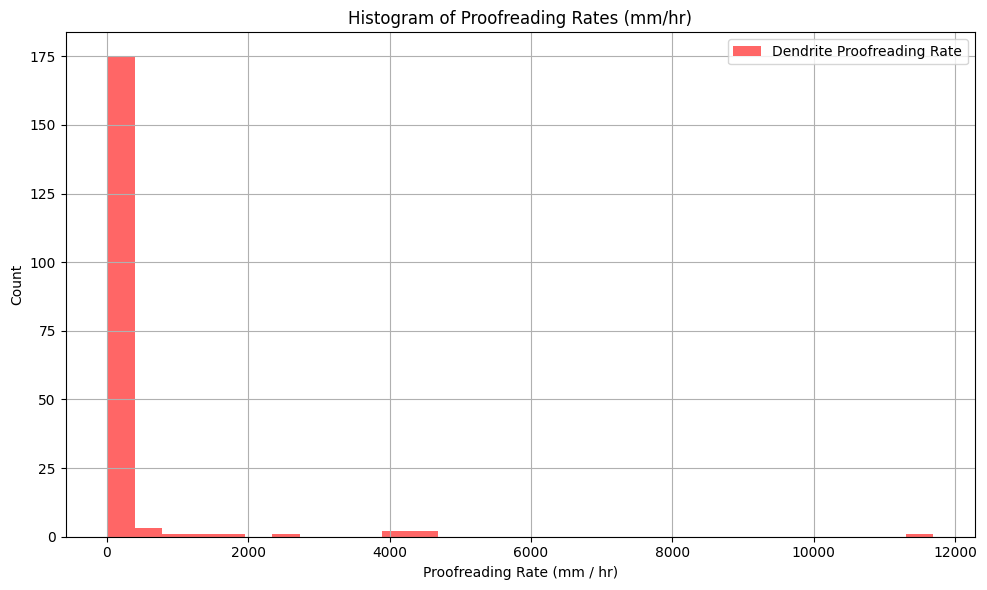

In [116]:
# Plot histograms
plt.figure(figsize=(10, 6))

#plt.hist(axon_rate, bins=30, alpha=0.6, label='Axon Proofreading Rate', color='blue')
#plt.hist(axon_sheet_rate, bins=30, alpha=0.6, label='Axon Sheet Proofreading Rate', color='green')
plt.hist(dendrite_rate, bins=30, alpha=0.6, label='Dendrite Proofreading Rate', color='red')

plt.xlabel('Proofreading Rate (mm / hr)')
plt.ylabel('Count')
plt.title('Histogram of Proofreading Rates (mm/hr)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [117]:
results.to_csv('AxonDendrite_Proofreading_Metrics_Filtered.csv')

### Old Full Cell

In [ ]:
def save_file(df_cleaned, filename):
    df_forsave = df_cleaned
    df_forsave.to_csv(filename)
    print("-----------------------------------------------------------")
    print(f"Saved: {filename}")
    print("-----------------------------------------------------------")

def update_segids_df(df, super_voxel_col):
    # Get the current date
    current_date = datetime.now().strftime('%Y%m%d')  # Format: YYYYMMDD
    
    # Update segids
    updated_segid_list = client.chunkedgraph.get_roots(df[super_voxel_col])
    
    # Add the updated segids to the DataFrame with the date in the column name
    updated_col_name = f"updated_segids_{current_date}"
    df[updated_col_name] = updated_segid_list
    
    print(f"Number of updated segids: {len(df)}")
    return df, updated_segid_list, current_date
    
def find_soma_position(skel, single_segid, df_cells, current_date):
    """
    Find the soma position by detecting the densest cluster of nodes in the skeleton.
    Returns False if there are not enough samples to form a valid cluster.
    """
    # Ensure single_segid is a string
    #single_segid = int(single_segid)  # Convert to string for proper matching

    # Filter matching row
    matching_row = df_cells[df_cells[f"updated_segids_{current_date}"] == single_segid]

    # Scale X, Y by 18 and Z by 45
    if not matching_row.empty:
        # Convert to numeric values AFTER filtering
        scaled_xyz = matching_row[['x', 'y', 'z']].astype(float).copy()  

        # Perform numeric scaling
        scaled_xyz['x'] *= 18
        scaled_xyz['y'] *= 18
        scaled_xyz['z'] *= 45

        # Convert to list
        soma_center = scaled_xyz[['x', 'y', 'z']].values.tolist()[0]  
        
    else:
        print(f"No match found for updated_segids_{current_date}: {single_segid}")
        soma_center = 0

    return soma_center
    
def find_and_remove_soma(skel, single_segid, df_cells, current_date, pyr_cell=True, plot_soma=False, plot_branches=False):
    soma_center = find_soma_position(skel, single_segid, df_cells, current_date)
    distances_ = np.linalg.norm(skel.nodes[["x", "y", "z"]].values - soma_center, axis=1)
    nodes_to_remove = skel.nodes["node_id"][distances_ <= 15000].tolist()
    skel = navis.remove_nodes(skel, which=nodes_to_remove, inplace=False)  
    return skel, soma_center

    
def setup_dataframe(dataframe, resume=False, col_name=None):

    if resume == False:
        # Remove rows where 'axon_length' or coordinates are NA
        df_cleaned = dataframe.dropna(subset=['axon_length', 'supervoxel'])

        print("-------------------------------------------------------")
        print(f"Getting Updated Segids for Dataframe of Length: {len(df_cleaned)}")
        print("-------------------------------------------------------")

        # Retrieve updated segment IDs for all supervoxels
        updated_segids = client.chunkedgraph.get_roots(df_cleaned['supervoxel'])

        # Assign the updated segment IDs back to the DataFrame
        current_date = datetime.now().strftime('%Y%m%d')  # Format: YYYYMMDD
        updated_col_name = f"updated_segids_{current_date}"
        df_cleaned[updated_col_name] = updated_segids
        
        # Initialize empty lists for storing results
        df_cleaned['time_list'] = [[] for _ in range(len(df_cleaned))]
        df_cleaned['time_sum'] = 0

        # Iterate through each row
        print("-------------------------------------------------------")
        print(f"Getting Time Data: {len(df_cleaned)}")
        print("-------------------------------------------------------")

        # Filter out rows where 'updated_segid' is 0 or less
        valid_rows = df_cleaned[df_cleaned[updated_col_name] > 0].copy()

        # Ensure the column retains integer format
        valid_rows[updated_col_name] = valid_rows[updated_col_name].astype('int64')

        # Extract all segment IDs for valid rows
        sids = valid_rows[updated_col_name].tolist()

        try:
            # Initialize an empty dictionary to store the results
            pyr_time_dicts = {}

            # Batch process to get the tabular change logs for all valid segment IDs
            for sid in tqdm(sids, desc="Processing Segment IDs"):
                pyr_time_dicts[sid] = client.chunkedgraph.get_tabular_change_log(sid, filtered=False)

            # Process timestamps in a batch
            def process_timestamps(pyr_time):
                time_list = []
                for val in pyr_time.values():
                    if 'timestamp' in val:
                        time_diff = [pd.Timedelta(i, unit='ms') / pd.Timedelta(hours=1) for i in val['timestamp'].diff()[1:]]
                        time_list.extend([time for time in time_diff if time <= 1])
                return time_list

            # Create columns for time_list and time_sum
            valid_rows['time_list'] = valid_rows[updated_col_name].map(
                lambda sid: process_timestamps(pyr_time_dicts.get(sid, {}))
            )
            valid_rows['time_sum'] = valid_rows['time_list'].map(sum)

            print(valid_rows['time_sum'])

        except Exception as e:
            print(f"Error processing segment IDs: {e}")
            valid_rows['time_list'] = [[] for _ in range(len(valid_rows))]
            valid_rows['time_sum'] = 0

        # Ensure integer columns remain integer after processing
        valid_rows[updated_col_name] = valid_rows[updated_col_name].astype('int64')

        # Merge processed data back into the original DataFrame
        df_cleaned = df_cleaned.merge(
            valid_rows[['time_list', 'time_sum', updated_col_name]], 
            on=updated_col_name, 
            how='left'
        )

        # Resolve duplicate columns after merge
        df_cleaned['time_list'] = df_cleaned['time_list_y'].combine_first(df_cleaned['time_list_x'])
        df_cleaned['time_sum'] = df_cleaned['time_sum_y'].combine_first(df_cleaned['time_sum_x'])

        # Drop unnecessary columns
        df_cleaned.drop(columns=['time_list_x', 'time_list_y', 'time_sum_x', 'time_sum_y'], inplace=True)
      
        # Save the cleaned DataFrame
        save_file(df_cleaned, 'df_preskeleton.csv')

    else:
        df_cleaned = dataframe
        updated_col_name = col_name

    # Iterate through each row
    print("-------------------------------------------------------")
    print(f"Getting Skeleton Data: {len(df_cleaned)}")
    print("-------------------------------------------------------")

    # Initialize empty lists for storing results
    df_cleaned['skeleton_length'] = 0

    # Iterate through each row
    for index, row in tqdm(df_cleaned.iterrows(), desc="Calculating skeleton length"):
        sid = row[updated_col_name]
        # Convert sid to an integer without losing precision
        if sid > 0:
            try:
                mesh_list = vol.mesh.get_navis(sid)
                skel = navis.skeletonize(mesh_list)                # Assuming 'skel' is the Skeleton object
                #df_cells = pd.read_csv('nuclei_table_250217 - nuclei.csv', dtype={'segid_0217': str, 'supervoxel': str, 'x': str, 'y': str, 'z': str})
                #current_date = datetime.now().strftime('%Y%m%d')
                #df_cells, _, _ = update_segids_df(df_cells, super_voxel_col='supervoxel')
                
                #skel, soma_center = find_and_remove_soma(skel, sid, df_cells, current_date, pyr_cell=True, plot_soma=False, plot_branches=False)
                skel = skel.prune_twigs(10000, inplace=False)
                
                total_length = skel.cable_length
                
                #skel.plot3d()

                # Update the DataFrame
                df_cleaned.at[index, 'skeleton_length'] = total_length
            except Exception as e:
                print(f"Error processing SID {sid}: {e}")
                df_cleaned.at[index, 'skeleton_length'] = 0
        else:
            # Update the DataFrame
            df_cleaned.at[index, 'skeleton_length'] = 0
            
    df_cleaned.to_csv('Proofreading_metrics_sheet.csv')

    return df_cleaned

def clean_final_dataframe(final_dataframe, axon=False):
    print("-------------------------------------------------------")
    print("Removing all zero time enteries")
    print("-------------------------------------------------------")
    df_cleaned_nozero = final_dataframe[final_dataframe['time_sum'] != 0]
    print(f"New Length is: {len(final_dataframe)}")
    print("-------------------------------------------------------")
    print("Removing all unreasonably short time enteries")
    print("-------------------------------------------------------")
    # EWH: removing all enteries under 3 minutes total time. 
    df_cleaned_nozero = df_cleaned_nozero[df_cleaned_nozero['time_sum'] >= 0.05]
    print(f"New Length is: {len(final_dataframe)}")
    print("-------------------------------------------------------")
    print("Removing all unreasonably short axons")
    print("-------------------------------------------------------")
    df_cleaned_nozero = df_cleaned_nozero[df_cleaned_nozero['axon_length'] >= 100]
    print(f"New Length is: {len(final_dataframe)}")
    if axon:
        print("-------------------------------------------------------")
        print("Calculating time per length of axon")
        print("-------------------------------------------------------")
        df_cleaned_nozero['axon_length_time'] = (((df_cleaned_nozero['axon_length']) / df_cleaned_nozero['time_sum']))/1000
        print(f"New Length is: {len(final_dataframe)}")
    else:
        print("-------------------------------------------------------")
        print("Calculating time per length of skeleton")
        print("-------------------------------------------------------")
        df_cleaned_nozero['skeleton_length_time'] = (((df_cleaned_nozero['skeleton_length']) / df_cleaned_nozero['time_sum']))/1000000
        print(f"New Length is: {len(final_dataframe)}")
    return df_cleaned_nozero 

def graph_histogram(dataframe, column):
    # Calculate the mean value of 'axon_length_time'
    mean_value = dataframe[column].mean()
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(dataframe[column], bins=100, edgecolor='black', alpha=0.7)

    # Add a red dashed line for the average value
    plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Average: {mean_value:.2f}')

    # Add labels, title, and legend
    plt.xlabel(f'{column} (mm/hour)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Histogram of Neuron Length Proofreading Rate', fontsize=14)
    plt.yscale('log')  # Set y-axis to log scale
    plt.legend(fontsize=12)
    
    plt.savefig('histo_publication_quality.png', dpi=900)
    
    # Display the plot
    plt.show()
    
    return plt
    
def graph_scatterplot(pyr_df, final_df, title, save_description, column, segid_name):
    
    print("-------------------------------------------------------")
    print("Finding Specific Cell Skeleton")
    print("-------------------------------------------------------")
    for index, row in tqdm(final_df.iterrows(), desc="Skeleton"):
        sid = row[segid_name]     
        skel = pcg_skel.pcg_skeleton(root_id=sid, client=client, root_point_resolution=True)
        # Assuming 'skel' is the Skeleton object
        vertices = skel.vertices  # The original vertices from the skeleton
        edges = skel.edges
        # Define the scaling factors for X, Y, and Z axes
        scale_factors = np.array([18, 18, 45])
        # Apply the scaling by dividing the vertices by the scaling factors
        scaled_vertices = vertices / scale_factors

    # Optional: Check the range of the scaled coordinates
    x_min, x_max = scaled_vertices[:, 0].min(), scaled_vertices[:, 0].max()
    y_min, y_max = scaled_vertices[:, 1].min(), scaled_vertices[:, 1].max()
    z_min, z_max = scaled_vertices[:, 2].min(), scaled_vertices[:, 2].max()
    # Assuming 'scaled_vertices' is the scaled skeleton vertices from the previous step
    vertices = scaled_vertices
    edges = skel.edges  # Edges from the skeleton object to connect vertices
    
    print("-------------------------------------------------------")
    print("Graphing Nuclei Locations and Skeleton")
    print("-------------------------------------------------------")

    size_limit = (24999, 2500)
    brown_cells = pyr_df[(pyr_df['size'] >= size_limit[1]) & (pyr_df['size'] <= size_limit[0])]
    size_limit = (64999, 25000)
    orange_cells = pyr_df[(pyr_df['size'] >= size_limit[1]) & (pyr_df['size'] <= size_limit[0])]
    size_limit = (109999, 65000)
    purple_cells = pyr_df[(pyr_df['size'] >= size_limit[1]) & (pyr_df['size'] <= size_limit[0])]
    size_limit = (231999, 110000)
    blue_cells = pyr_df[(pyr_df['size'] >= size_limit[1]) & (pyr_df['size'] <= size_limit[0])]
    size_limit = (311999, 232000)
    red_cells = pyr_df[(pyr_df['size'] >= size_limit[1]) & (pyr_df['size'] <= size_limit[0])]
    size_limit = (450000, 312000)
    green_cells = pyr_df[(pyr_df['size'] >= size_limit[1]) & (pyr_df['size'] <= size_limit[0])]

    # Define the color palette
    colors = sns.color_palette("bright", 5)
    # Plot the scatter plot
    plt.figure(figsize=(7, 8))
    plt.scatter(green_cells['x'], green_cells['y'], color=colors[1], marker='o', s=4, label='Pyr Big Cells')
    plt.scatter(red_cells['x'], red_cells['y'], color=colors[0], marker='o', s=4, label='Pyr Small Cells')
    # Plot each edge by connecting corresponding vertex pairs
    for edge in edges:
        point1 = vertices[edge[0]]
        point2 = vertices[edge[1]]
        xs, ys = [point1[0], point2[0]], [point1[1], point2[1]]  # Project onto X-Y
        plt.plot(xs, ys, color='black', lw=1.0)
    plt.title(f'{title} : {row[column]}')
    # Add legend for only Green, Red, and Blue Cells
    plt.legend(loc='lower left')
    # Save as a high-resolution image for publication
    plt.savefig(f'scatterplot_publication_quality_{save_description}.png', dpi=900)
    plt.show()
    
    return plt

def graph_scatter(df, item_1, item_2):

    # Drop rows with missing Z or GT_MF_Counts
    df = df.dropna(subset=['curve_distance', 'axon_length'])

    # Plot each point individually
    plt.figure(figsize=(10, 6))
    for i, row in df.iterrows():
        plt.scatter(
            row[item_1],
            row[item_2],
            c='black',
            edgecolor='black',
            linewidth=1,
            s=30,
            alpha=0.85
        )

    # Labels
    plt.xlabel(item_1, fontsize=16)
    plt.ylabel(item_2, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.savefig('Scatterplot_Pyr_Proofreading.png', dpi=600)
    plt.show()
    
    return

def graph_overall():
    fig = plt.figure(figsize=(10, 8))  # Adjust the figure size
    gs = gridspec.GridSpec(3, 4, height_ratios=[2, 1, 1], width_ratios=[1, 1, 1, 1])

    # Main histogram spanning the entire first row
    graph0_ax = fig.add_subplot(gs[0, :])
    img0 = mpimg.imread('histo_publication_quality.png')
    graph0_ax.imshow(img0)
    graph0_ax.axis('off')  # Turn off axes for better display

    # Scatterplot graphs in the second and third rows, evenly distributed
    graph1_ax = fig.add_subplot(gs[1, 0])
    graph2_ax = fig.add_subplot(gs[1, 1])
    graph3_ax = fig.add_subplot(gs[1, 2])
    graph4_ax = fig.add_subplot(gs[1, 3])

    # Load and display the scatterplot images
    img1 = mpimg.imread('scatterplot_publication_quality_Fastest_Rate.png')
    graph1_ax.imshow(img1)
    graph1_ax.axis('off')  # Turn off axes for better display

    img2 = mpimg.imread('scatterplot_publication_quality_Slowest_Rate.png')
    graph2_ax.imshow(img2)
    graph2_ax.axis('off')  # Turn off axes for better display

    img3 = mpimg.imread('scatterplot_publication_quality_Shortest_Time.png')
    graph3_ax.imshow(img3)
    graph3_ax.axis('off')  # Turn off axes for better display

    img4 = mpimg.imread('scatterplot_publication_quality_Longest_Time.png')
    graph4_ax.imshow(img4)
    graph4_ax.axis('off')  # Turn off axes for better display

    # Adjust layout for tighter spacing
    plt.tight_layout(h_pad=0.5, w_pad=0.5)  # Reduce horizontal and vertical padding
    plt.subplots_adjust(hspace=0.2, wspace=0.1)  # Fine-tune spacing between plots

    plt.savefig("high_resolution_plot_tight.png", dpi=300)
    plt.show()

In [ ]:
df = pd.read_csv('all_pyramidal_cells - all_pyr_v2_remove_dupes.csv')

In [ ]:
#df_preskel = pd.read_csv('df_preskeleton.csv', dtype={'updated_segids_20250103': 'int64'})
df = df.head(50)
df_final = setup_dataframe(df, resume=False, col_name='updated_segids_20250404')
print("-------- DONE ----------")

In [ ]:
print(df_final.columns)

In [ ]:
df_final.to_csv('Proofreading_metrics_sheet.csv')

In [ ]:
graph_scatter(df, item_1='curve_distance', item_2='axon_length')

In [ ]:
df_scatterplot_max = df_final_cleaned[df_final_cleaned['skeleton_length_time'] == df_final_cleaned['skeleton_length_time'].max()]
print(df_scatterplot_max)
graph_fastest_rate = graph_scatterplot(pyr_df, df_scatterplot_max, title='Fastest Proofread Rate Cell', \
                  save_description='Fastest_Rate', column='skeleton_length_time', segid_name='updated_segids_20250103')

In [ ]:
graph_overall()